In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
file_path = '/content/drive/MyDrive/Colab Notebooks/CSE_151A/Proj1/processed_credit_card_data.csv'
df = pd.read_csv(file_path).iloc[:, 1:]
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,...,JOB_Laborers,JOB_Low-skill Laborers,JOB_Managers,JOB_Medicine staff,JOB_Private service staff,JOB_Realty agents,JOB_Sales staff,JOB_Secretaries,JOB_Security staff,JOB_Waiters/barmen staff
0,5065438,0,1,0,2,0.699862,1,0.513099,0.854549,0,...,False,False,True,False,False,False,False,False,False,False
1,5142753,0,0,0,0,-1.115022,1,-0.838610,0.977064,1,...,False,False,False,False,True,False,False,False,False,False
2,5111146,1,1,1,0,0.699862,3,-1.337086,0.935589,0,...,True,False,False,False,False,False,False,False,False,False
3,5010310,0,1,1,1,-0.812541,1,-0.028697,0.876465,0,...,False,False,False,False,False,False,False,False,False,False
4,5010835,1,1,1,2,-0.553272,1,-0.664451,0.645706,1,...,False,False,False,False,False,False,False,False,False,False


## To address the challenges of the imbalanced dataset, we will adopt the XGBoost model, leveraging its built-in capabilities such as scale_pos_weight and advanced handling of skewed class distributions.

In [20]:
X = df.drop(columns=['ID', 'TARGET'])  # Drop ID and TARGET for features
y = df['TARGET']  # TARGET column as the target variable


X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (376366, 42)
X_test shape: (161301, 42)
y_train shape: (376366,)
y_test shape: (161301,)


In [27]:
param_grid = {
    'n_estimators': [50, 100,150,200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5],
    'gamma': [0, 0.1],
    'scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]  # Adjust imbalance
}


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(accuracy_score),
    cv=3,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:07:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 273.1194464675892}


Training Error: 0.0
Test Error: 0.0
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    160712
           1       1.00      1.00      1.00       589

    accuracy                           1.00    161301
   macro avg       1.00      1.00      1.00    161301
weighted avg       1.00      1.00      1.00    161301

Confusion Matrix:
[[160712      0]
 [     0    589]]


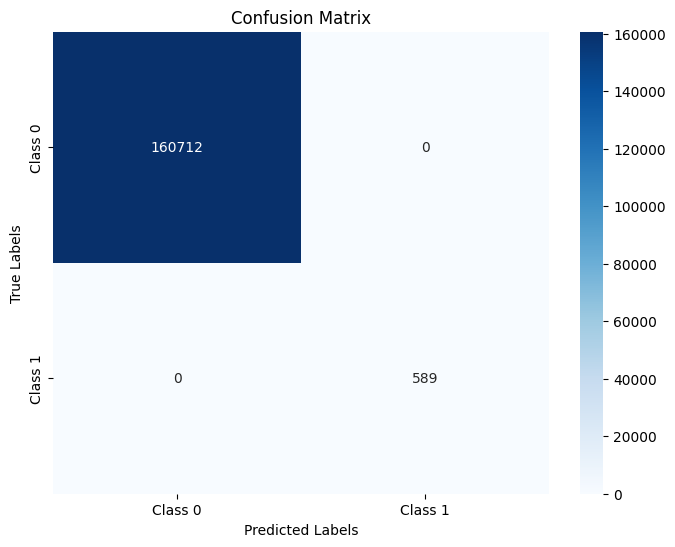

In [32]:
# Predictions on training and test sets
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

print(f"Training Error: {train_error}")
print(f"Test Error: {test_error}")


# Classification report
print("Test Classification Report:")
print(classification_report(y_test, test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Although our model achieved 100% accuracy on both the training and test datasets, this result might not indicate true generalization or robustness due to the highly imbalanced dataset. The class distribution is heavily skewed, with 160,712 instances of class 0 and only 589 instances of class 1. Such imbalance can cause the model to focus predominantly on the majority class, which may lead to overly optimistic metrics.

To address these concerns, we are planning to use following methods to provide a more realistic evaluation of the model's generalization capabilities and address potential limitations of the current results

Regularization: Use reg_alpha and reg_lambda to reduce overfitting and ensure the model is robust to variations.
Class Imbalance: Explore oversampling (e.g., SMOTE), downsampling, or a hybrid approach to validate the model's performance across more realistic class distributions.